In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.nn import GCNConv, Set2Set, GNNExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
import os

import matplotlib.pyplot as plt
from dgl.data import BACommunityDataset
import networkx as nx
import torch_geometric
import dgl


In [5]:
from src.model import *
from src.data import *
from src.explainer import *
from src.plot import *
from src.modify import *
from src.protgnn import *

In [6]:
ba_dataset = get_dataset("BAShapes")

Done loading data from cached files.


C:\Users\Yurt\anaconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
num_classes = len(set([int(i) for i in ba_dataset.y]))
num_features = ba_dataset.x.shape[-1]

In [8]:
epochs = 3000
dim = 20

## GCExplainer

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features=num_features, dim=dim, num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)


In [10]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model)

[Train_loss:0.179172 Train_acc: 0.9750, Test_acc: 0.9071]: 100%|███████████████████| 3000/3000 [00:32<00:00, 92.35it/s]


In [11]:
gce_explainer = GCExplainer()

In [12]:
gce_explainer.learn_prototypes(model,ba_dataset)

C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Yurt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [13]:
gce_explainer.get_prediction(model,ba_dataset)

array([3, 3, 0, 3, 1, 0, 3, 3, 0, 0, 2, 0, 1, 2, 2, 0, 3, 3, 0, 3, 0, 2,
       2, 3, 2, 3, 2, 0, 0, 0, 2, 2, 3, 3, 3, 0, 0, 0, 3, 3, 2, 0, 2, 2,
       0, 0, 3, 2, 3, 0, 0, 3, 2, 3, 0, 2, 3, 1, 0, 0, 2, 1, 0, 2, 3, 3,
       3, 3, 0, 3, 2, 2, 2, 0, 2, 0, 0, 1, 3, 0, 2, 2, 0, 3, 0, 0, 0, 3,
       0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 2, 0, 3, 0, 0, 2, 1], dtype=int64)

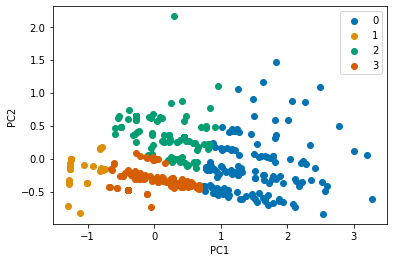

In [14]:
plot_kmeans_clusters(gce_explainer.kmeans,gce_explainer.initial_activations)

In [15]:
gce_explainer.get_prediction(model,identity(ba_dataset))

array([3, 3, 0, 3, 1, 0, 3, 3, 0, 0, 2, 0, 1, 2, 2, 0, 3, 3, 0, 3, 0, 2,
       2, 3, 2, 3, 2, 0, 0, 0, 2, 2, 3, 3, 3, 0, 0, 0, 3, 3, 2, 0, 2, 2,
       0, 0, 3, 2, 3, 0, 0, 3, 2, 3, 0, 2, 3, 1, 0, 0, 2, 1, 0, 2, 3, 3,
       3, 3, 0, 3, 2, 2, 2, 0, 2, 0, 0, 1, 3, 0, 2, 2, 0, 3, 0, 0, 0, 3,
       0, 0, 3, 0, 3, 0, 0, 3, 0, 3, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 2, 0, 3, 0, 0, 2, 1], dtype=int64)

## ProtGNN

In [16]:
model = GCNNet_NC(num_features, num_classes, model_args).to(device)

In [17]:
model.load_state_dict(torch.load("../models/protgnn_bashapes.pt"))

FileNotFoundError: [Errno 2] No such file or directory: '../models/protgnn_bashapes.pt'

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [19]:
model = train_model(300,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:0.100143 Train_acc: 0.9786, Test_acc: 0.9357]: 100%|█████████████████████| 300/300 [00:08<00:00, 34.74it/s]


In [20]:
prot_explainer = ProtGNNExplainer()

In [21]:
prot_explainer.learn_prototypes(model,ba_dataset)

In [22]:
prot_explainer.get_prediction(model,ba_dataset)

array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19,  8, 17, 17, 19, 19,  8, 17,
       17, 19,  8, 17, 17, 19,  8, 17, 17,  8, 17, 17, 19, 19,  8, 17, 17,
       19, 19, 19, 17,  8, 17, 19, 19,  8, 17, 17, 19, 19,  8, 17, 17,  8,
       17, 17,  8, 17, 17,  8, 17, 17, 19,  8, 17, 17,  8, 17, 17,  8, 17,
       17,  8, 19, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,  8,
       17, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,
        8, 17, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17,  8, 17,
       17,  8, 17, 17, 19,  8,  5, 17,  8, 17, 17,  8, 17, 17, 17, 19, 19,
       19,  8, 17, 17,  8, 17, 17, 19, 19, 17,  8, 17, 17,  8, 17, 17, 19,
       19,  8, 17,  8, 17,  8, 17, 17,  8, 17, 17,  8, 17, 17, 19, 19,  8,
       17, 17,  8, 17, 17, 19,  8, 17, 17,  8, 17, 17,  5, 19, 19,  8,  3,
       17, 17,  8, 17, 17

## CDM

In [23]:
model = GCN(num_features=num_features, dim=dim, num_classes=num_classes)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-3)

In [28]:
model = train_model(epochs,model,device,ba_dataset,optimizer,test_model,get_outputs=lambda a: a[1])

[Train_loss:5.255492 Train_acc: 0.9857, Test_acc: 0.9214]: 100%|███████████████████| 3000/3000 [00:50<00:00, 59.67it/s]


In [29]:
cdm_explainer = CDMExplainer()

In [30]:
cdm_explainer.learn_prototypes(model, ba_dataset)

In [32]:
cdm_explainer.get_prediction(model, ba_dataset)

Explanation class 0: ~feature0000000000 - acc. = 0.9357 - compl. = 1.0000
Explanation class 1: ~feature0000000000 & ~feature0000000003 & ~feature0000000011 & ~feature0000000015 - acc. = 0.9571 - compl. = 4.0000
Explanation class 2: feature0000000010 - acc. = 0.9357 - compl. = 1.0000
Explanation class 3: feature0000000008 - acc. = 0.8786 - compl. = 1.0000


{'0': {'explanation': '~feature0000000000',
  'explanation_accuracy': 0.9357142857142857,
  'explanation_complexity': 1},
 '1': {'explanation': '~feature0000000000 & ~feature0000000003 & ~feature0000000011 & ~feature0000000015',
  'explanation_accuracy': 0.9571428571428572,
  'explanation_complexity': 4},
 '2': {'explanation': 'feature0000000010',
  'explanation_accuracy': 0.9357142857142857,
  'explanation_complexity': 1},
 '3': {'explanation': 'feature0000000008',
  'explanation_accuracy': 0.8785714285714286,
  'explanation_complexity': 1}}

## Adversary Methods

In [33]:
ba_aggressive = aggressive_adversary(ba_dataset,0.1)

In [34]:
ba_aggressive.edge_index.int()

tensor([[ 44,  49,  53,  ..., 110, 110,  39],
        [  0,   1,   2,  ..., 628, 186, 602]], dtype=torch.int32)

In [35]:
ba_conservative = conservative_adversary(ba_dataset, 'BAShapes', 0.1)

In [36]:
ba_conservative.edge_index.int()

tensor([[ 44,  49,  53,  ..., 639, 694, 694],
        [  0,   1,   2,  ..., 464, 464, 635]], dtype=torch.int32)

## Plot Prelim Results

In [ ]:
plot_metric('results', 'bashapes', 'Fidelity')